# Import Libraries
I use **NumPy, Pandas, OpenCV, and scikit-learn** for data manipulation, preprocessing, and splitting. For visualizing data and results I use **Matplotlib**. And finally use **TensorFlow/Keras** to build and train deep learning models with various layers and callbacks. 

In [26]:
import os
import random
import numpy as np
import pandas as pd
import cv2 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Input, UpSampling2D, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing import image

from glob import glob
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

from rich.console import Console
from rich.table import Table

I also set a seed for reproducibility and consistent results across runs:

In [27]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [28]:
dataset_path = 'C:/Users/Yadav Ji/Desktop/BrainAI_framework/BrainAI_Framework/datasets/sementation_dataset/kaggle_3m'

patients = os.listdir(dataset_path)
print(f"Total patients in the dataset: {len(patients)}")

Total patients in the dataset: 112


I explore the files in a sample patient's folder to understand the dataset structure, where each patient's image is in `.tif` format, and the corresponding mask file ends with `_mask` in its name.

In [29]:
example_patient = random.choice(patients)
example_patient_path = os.path.join(dataset_path, example_patient)
print(f"Files in {example_patient}:")
print(os.listdir(example_patient_path))

Files in TCGA_HT_7605_19950916:
['TCGA_HT_7605_19950916_1.tif', 'TCGA_HT_7605_19950916_10.tif', 'TCGA_HT_7605_19950916_10_mask.tif', 'TCGA_HT_7605_19950916_11.tif', 'TCGA_HT_7605_19950916_11_mask.tif', 'TCGA_HT_7605_19950916_12.tif', 'TCGA_HT_7605_19950916_12_mask.tif', 'TCGA_HT_7605_19950916_13.tif', 'TCGA_HT_7605_19950916_13_mask.tif', 'TCGA_HT_7605_19950916_14.tif', 'TCGA_HT_7605_19950916_14_mask.tif', 'TCGA_HT_7605_19950916_15.tif', 'TCGA_HT_7605_19950916_15_mask.tif', 'TCGA_HT_7605_19950916_16.tif', 'TCGA_HT_7605_19950916_16_mask.tif', 'TCGA_HT_7605_19950916_17.tif', 'TCGA_HT_7605_19950916_17_mask.tif', 'TCGA_HT_7605_19950916_18.tif', 'TCGA_HT_7605_19950916_18_mask.tif', 'TCGA_HT_7605_19950916_19.tif', 'TCGA_HT_7605_19950916_19_mask.tif', 'TCGA_HT_7605_19950916_1_mask.tif', 'TCGA_HT_7605_19950916_2.tif', 'TCGA_HT_7605_19950916_20.tif', 'TCGA_HT_7605_19950916_20_mask.tif', 'TCGA_HT_7605_19950916_21.tif', 'TCGA_HT_7605_19950916_21_mask.tif', 'TCGA_HT_7605_19950916_22.tif', 'TCGA_HT_

Then, I'll get image and mask paths for the example patient:

In [30]:
def get_image_mask_paths(patient_path):
    image_paths = glob(os.path.join(patient_path, '*.tif'))
    mask_paths = [path for path in image_paths if 'mask' in os.path.basename(path)]
    image_paths = [path for path in image_paths if 'mask' not in os.path.basename(path)]
    return image_paths, mask_paths

image_paths, mask_paths = get_image_mask_paths(example_patient_path)
print(f"Number of images: {len(image_paths)}, Number of masks: {len(mask_paths)}")

Number of images: 32, Number of masks: 32


## Display 10 Images and Their Corresponding Masks
- I'll randomly selects 10 images and their corresponding mask paths
- Each image is read and converted to RGB format, while masks are read in color format.  
- Contours from the mask are extracted using `cv2.findContours` and overlaid on the image in red using `cv2.drawContours`.  
- The visualization is arranged in three columns: the image, the mask, and the image with the mask overlaid.  

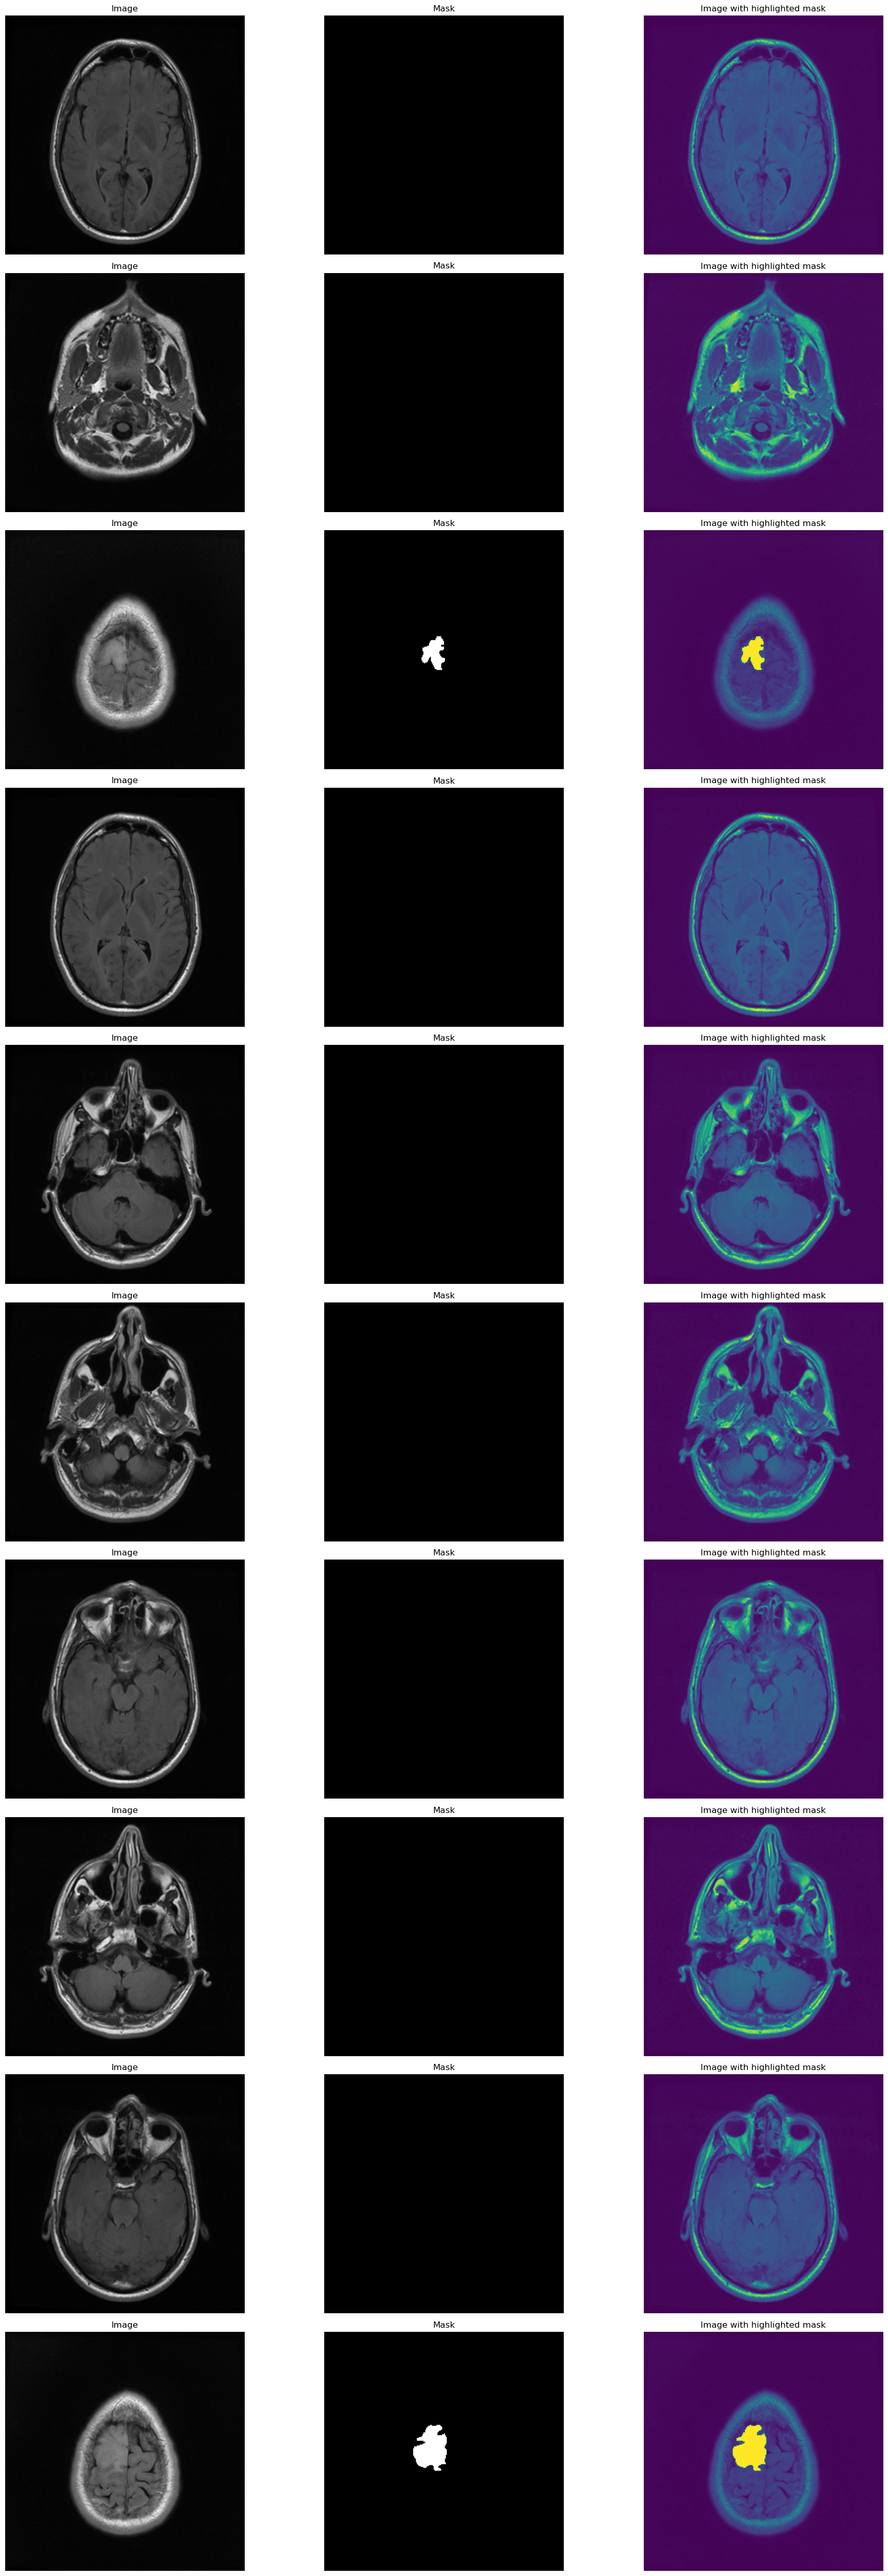

In [31]:
num_images_to_display = 10
selected_image_paths = random.sample(image_paths, num_images_to_display)
selected_mask_paths = [path.replace('.tif', '_mask.tif') for path in selected_image_paths]

plt.figure(figsize=(20, 5 * num_images_to_display))

for i, (img_path, mask_path) in enumerate(zip(selected_image_paths, selected_mask_paths)):
    # Read the image and mask
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    
    # Plot image
    plt.subplot(num_images_to_display, 3, 3 * i + 1)
    plt.imshow(img, cmap='gray')
    plt.title('Image')
    plt.axis('off')
    
    # Plot mask
    plt.subplot(num_images_to_display, 3, 3 * i + 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    # Plot image with highlighted mask
    img_copy = img.copy()
    contours, hier = cv2.findContours(mask[:, :, 0], cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask_over_image = cv2.drawContours(img_copy, contours, -1, [255, 0, 0], thickness=-1)
    plt.subplot(num_images_to_display, 3, 3 * i + 3)
    plt.imshow(mask_over_image)
    plt.title('Image with highlighted mask')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

---

# 2. Preprocessing

## Implement Image Preprocessing Techniques
I define a function to load and preprocess images and their corresponding masks from the dataset.
- Read the image in RGB, resize to `128x128`, normalize to `[0, 1]`, and append to `X`.  
- Read the mask in grayscale, resize to `128x128`, normalize to `[0, 1]`, threshold (values > 0.5 set to 1, others to 0), and append to `Y`.  

**Note:** I use `tqdm` library to display progress bars for loops to track progress. In the code, it wraps the `for` loop over `patient_ids` to show how many patient folders have been processed.

In [32]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

def load_and_preprocess_data(data_path, img_height, img_width):
    X = []
    Y = []
    folder_ids = os.listdir(data_path)
    for folder_id in tqdm(folder_ids, desc='Preprocess Images and Masks'):
        folder_path = os.path.join(data_path, folder_id)
        image_paths, _ = get_image_mask_paths(folder_path)
        for img_path in image_paths:
            # Read image
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Resize image
            img = cv2.resize(img, (img_width, img_height))
            # Normalize image
            img = img / 255.0
            X.append(img)
            
            # Corresponding mask
            mask_path = img_path.replace('.tif', '_mask.tif')
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            # Resize mask
            mask = cv2.resize(mask, (img_width, img_height))
            # Normalize mask
            mask = mask / 255.0
            # Threshold mask
            mask = np.where(mask > 0.5, 1.0, 0.0)
            Y.append(mask)
    X = np.array(X)
    Y = np.array(Y)
    Y = np.expand_dims(Y, axis=-1)
    print(f"Shape of X: {X.shape}")
    print(f"Shape of Y: {Y.shape}")
    return X, Y

## Load and Preprocess the Dataset

In [33]:
X, Y = load_and_preprocess_data(dataset_path, IMG_HEIGHT, IMG_WIDTH)

Preprocess Images and Masks:   0%|          | 0/112 [00:00<?, ?it/s]

Shape of X: (3929, 128, 128, 3)
Shape of Y: (3929, 128, 128, 1)


## Split the Dataset into Train, Validation, and Test Sets (80-10-10)

In [34]:
# First, split into train and temp (train is 80%, temp is 20%)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=seed)

# Then split temp into validation and test (each 10%)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=seed)

print(f"Training set size: {X_train.shape[0]} images")
print(f"Validation set size: {X_val.shape[0]} images")
print(f"Test set size: {X_test.shape[0]} images")

Training set size: 3143 images
Validation set size: 393 images
Test set size: 393 images


## Display 10 Images and Their Corresponding Masks After Preprocessing

I randomly select and display 10 pairs of preprocessed images and their corresponding masks from training dataset.

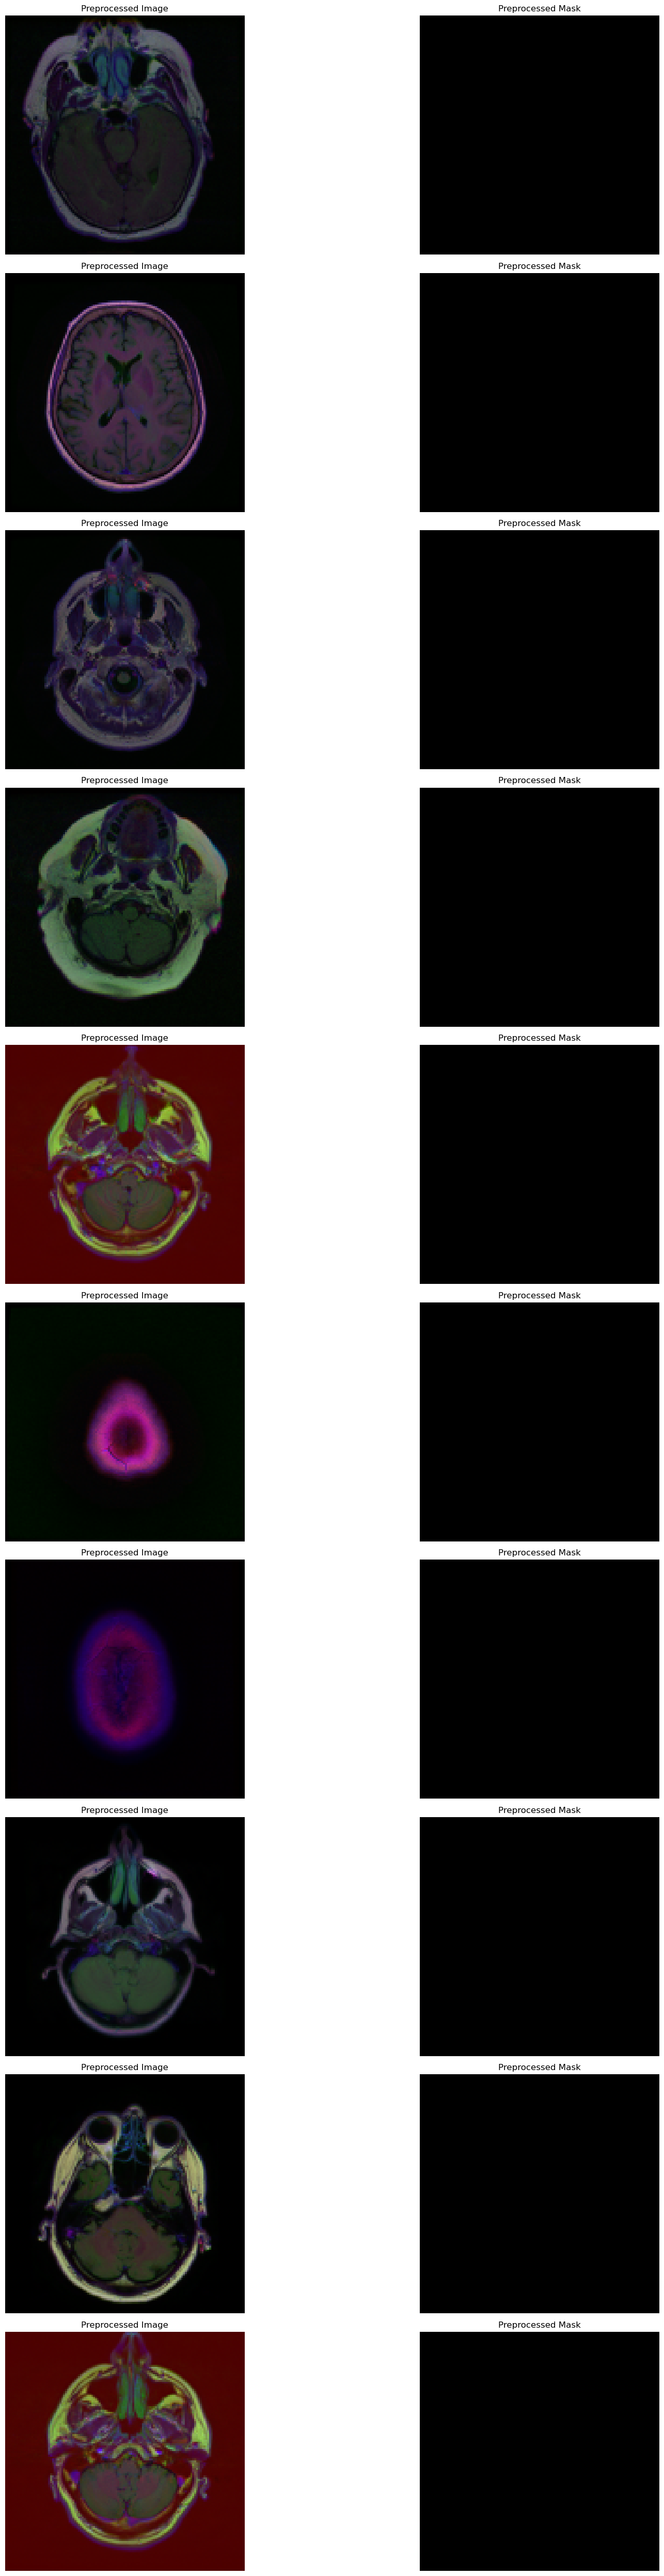

In [35]:
num_images_to_display = 10
indices = random.sample(range(X_train.shape[0]), num_images_to_display)

plt.figure(figsize=(20, num_images_to_display * 5))
for i, idx in enumerate(indices):
    img = X_train[idx]
    mask = Y_train[idx].squeeze()
    
    # Plot image
    plt.subplot(num_images_to_display, 2, 2 * i + 1)
    plt.imshow(img, cmap='gray')
    plt.title('Preprocessed Image')
    plt.axis('off')
    
    # Plot mask
    plt.subplot(num_images_to_display, 2, 2 * i + 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Preprocessed Mask')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

---

 # 3. Implementation, Training, and Validation of the Model

## Implement a U-Net Model Using the Main Article

![U-Net model](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

I implement the U-Net with an **encoding path (downsampling)** to extract features, a **bottleneck** for deep feature representation, and a **decoding path (upsampling)** to reconstruct the segmented output. Also I use **skip connections** to merge spatial information from the encoding path with upsampled feature maps in the decoding path, to improve segmentation accuracy. The model outputs a single-channel image which is ideal for binary segmentation tasks. Below is the detailed defenition of each part of the code:

### 1. **Input Layer**
   - **`inputs = Input(input_size)`**:  
     - The input layer defines the shape of the input data, which is specified as `(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)`.  
     - I preprocess images to size 128x128 with 3 channels.  
     - The input layer serves as the starting point for the U-Net architecture.

### 2. **Encoding Path (Downsampling)**  
   - The encoding path extracts features from the input image while progressively reducing the spatial dimensions (height and width) using **convolutions** and **max-pooling**.  
   - For each block in the encoding path:
     - Two `Conv2D` layers
     - A `MaxPooling2D` layer is used to downsample the feature map by reducing its dimensions by half.  
   - **Steps in the encoding path:**
     - **Block 1:**
       - Apply two `Conv2D` layers with 64 filters each.
       - Downsample using `MaxPooling2D` (reduces dimensions to half).
     - **Block 2:**
       - Apply two `Conv2D` layers with 128 filters each.
       - Downsample using `MaxPooling2D`.
     - **Block 3:**
       - Apply two `Conv2D` layers with 256 filters each.
       - Downsample using `MaxPooling2D`.
     - **Block 4:**
       - Apply two `Conv2D` layers with 512 filters each.
       - Downsample using `MaxPooling2D`.

### 3. **Bottleneck**
   - The bottleneck is the deepest part of the U-Net, where the feature maps have the smallest spatial dimensions but the highest number of filters.  
   - **`c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)`**:  
     - Two `Conv2D` layers with 1024 filters are applied to extract deep features from the input.  
     - This part captures the most abstract and high-level features of the image.

### 4. **Decoding Path (Upsampling)**  
   - The decoding path reconstructs the spatial dimensions of the feature maps to match the original input size.  
   - It uses **upsampling** to increase the spatial dimensions and **skip connections** to merge information from the corresponding encoding layers.  
   - For each block in the decoding path:
     - **`UpSampling2D`** is used to increase the spatial dimensions by a factor of 2.
     - **`concatenate`** merges the upsampled feature map with the corresponding feature map from the encoding path (skip connection).  
     - Two `Conv2D` layers are applied to refine the feature map.  
   - **Steps in the decoding path:**
     - **Block 1:**
       - Upsample the bottleneck output and concatenate it with the output of the 4th encoding block (`c4`).
       - Apply two `Conv2D` layers with 512 filters.
     - **Block 2:**
       - Upsample and concatenate with the output of the 3rd encoding block (`c3`).
       - Apply two `Conv2D` layers with 256 filters.
     - **Block 3:**
       - Upsample and concatenate with the output of the 2nd encoding block (`c2`).
       - Apply two `Conv2D` layers with 128 filters.
     - **Block 4:**
       - Upsample and concatenate with the output of the 1st encoding block (`c1`).
       - Apply two `Conv2D` layers with 64 filters.

### 5. **Output Layer**
   - **`outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)`**:  
     - A `Conv2D` layer with a single filter (1x1 kernel) is applied to reduce the feature map to a single channel.  
     - The `sigmoid` activation function is used to produce pixel-wise probabilities, making it suitable for binary segmentation tasks.

### 6. **Model Definition**
   - **`model = Model(inputs=[inputs], outputs=[outputs])`**:  
     - The Keras Functional API is used to define the U-Net model by specifying the input and output layers.  


To have a cleaner code, I defined two methods for creating **downsampling** and **upsampling** blocks.



The `downsample` function performs a downsampling step using two `Conv2D` layers with a default kernel size of (3, 3), followed by `MaxPooling2D`. I use the `relu` activation function and set padding to `same` to maintain the spatial dimensions.

In [36]:
def downsample(inputs, filters, kernel_size=(3, 3), pool_size=(2, 2)):
    c = Conv2D(filters, kernel_size, activation='relu', padding='same')(inputs)
    c = Conv2D(filters, kernel_size, activation='relu', padding='same')(c)
    
    p = MaxPooling2D(pool_size)(c)
    
    return c, p

The `upsample` method executes an upsampling step with `UpSampling2D`, concatenation with a skip connection, followed by two `Conv2D` layers. Similarly, the `relu` activation function is used, with padding set to `same`.

In [37]:
def upsample(inputs, skip_connection, filters, kernel_size=(3, 3)):
    u = UpSampling2D((2, 2))(inputs)

    u = concatenate([u, skip_connection], axis=3)
    
    c = Conv2D(filters, kernel_size, activation='relu', padding='same')(u)
    c = Conv2D(filters, kernel_size, activation='relu', padding='same')(c)
    
    return c

This function defines a U-Net model architecture with an encoding path for downsampling, a bottleneck, and a decoding path for upsampling. Finally, it produces a single-channel output with a `sigmoid` activation.

In [38]:
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)
    
    # Encoding path
    c1, p1 = downsample(inputs, 64)
    c2, p2 = downsample(p1, 128)
    c3, p3 = downsample(p2, 256)
    c4, p4 = downsample(p3, 512)
    
    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoding path
    c6 = upsample(c5, c4, 512)
    c7 = upsample(c6, c3, 256)
    c8 = upsample(c7, c2, 128)
    c9 = upsample(c8, c1, 64)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

## Compile the Model
Next, I initializes the U-Net model, compiles it with the `adam` optimizer. 

I use `binary_crossentropy` because this is a binary classification task where each pixel is classified as either tumor (foreground) or brain (background). This loss is ideal for comparing the predicted probability map (0 to 1) with the binary ground truth mask (0 or 1).

Also I used the `accuracy` metric evaluates the proportion of correctly classified pixels.

However, there are better loss functions and metrics for this problem, which we will evaluate later using an enhanced U-Net model.

In [39]:
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 512) │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 16, 16,    │          0 │ conv2d_28[0][0]   │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 16, 16,    │          0 │ up_sampling2d_4[

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
import os

dataset_path = "C:/Users/Yadav Ji/Desktop/BrainAI_framework/BrainAI_Framework/datasets/sementation_dataset/kaggle_3m"
image_files = os.listdir(dataset_path)

print(f"Found {len(image_files)} files: {image_files[:10]}")  # Print first 10 files


Found 112 files: ['data.csv', 'README.md', 'TCGA_CS_4941_19960909', 'TCGA_CS_4942_19970222', 'TCGA_CS_4943_20000902', 'TCGA_CS_4944_20010208', 'TCGA_CS_5393_19990606', 'TCGA_CS_5395_19981004', 'TCGA_CS_5396_20010302', 'TCGA_CS_5397_20010315']


In [78]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6, verbose=1),
    ModelCheckpoint('model-brain-mri-segmentation.weights.h5', save_best_only=True, save_weights_only=True, verbose=1)
]

In [73]:
BATCH_SIZE = 32
EPOCHS = 2

## Train the Model

In [ ]:
results = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/2
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 47s/step - accuracy: 0.9858 - loss: 0.3432 
Epoch 1: val_loss improved from inf to 0.03111, saving model to model-brain-mri-segmentation.weights.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 4776s 48s/step - accuracy: 0.9859 - loss: 0.3410 - val_accuracy: 0.9901 - val_loss: 0.0311 - learning_rate: 0.0010
Epoch 2/2
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 71s/step - accuracy: 0.9894 - loss: 0.0291  
Epoch 2: val_loss improved from 0.03111 to 0.02961, saving model to model-brain-mri-segmentation.weights.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 7052s 72s/step - accuracy: 0.9894 - loss: 0.0291 - val_accuracy: 0.9901 - val_loss: 0.0296 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.


## Report and Plot Performance Metrics During Training and Validation Phases

I visualize the training and validation accuracy and loss over epochs to gain insights into my model's performance during training.

In [ ]:
def plot_metrics(history, metrics):
    plt.figure(figsize=(12, 6))
    epochs_range = range(len(history.history[metrics[0]]))
    
    for i, metric in enumerate(metrics):
        plt.subplot(len(metrics) // 2 + len(metrics) % 2, 2, i + 1)
        plt.plot(epochs_range, history.history[metric], label=f'Training {metric.capitalize()}')
        plt.plot(epochs_range, history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
        plt.title(f'Model {metric.capitalize()}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
    
    plt.tight_layout()
    plt.show()

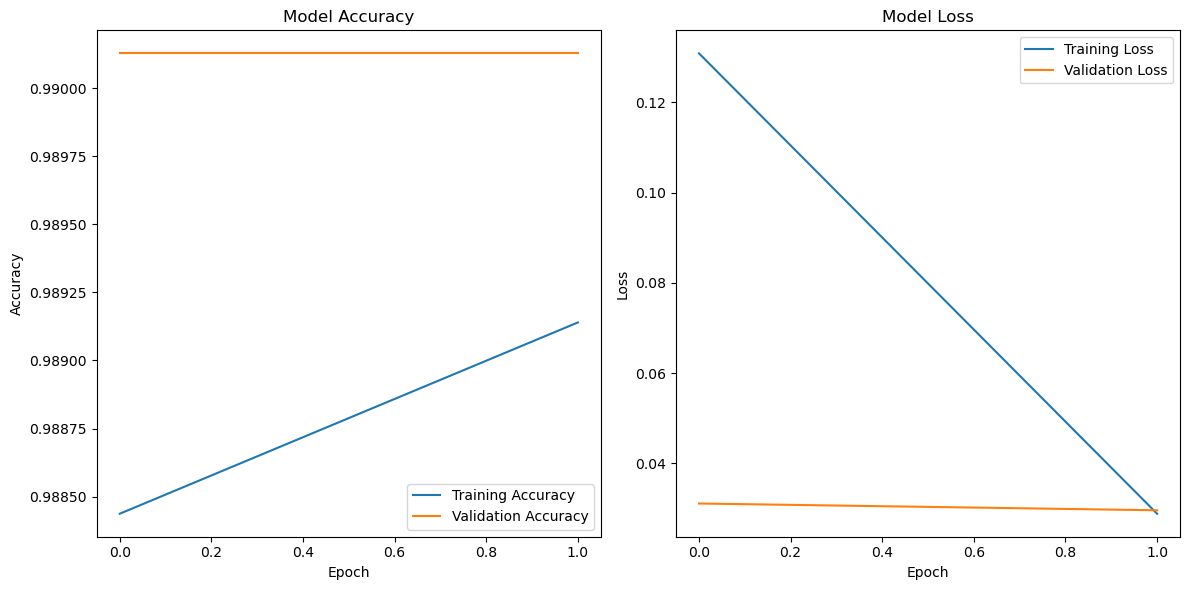

In [ ]:
plot_metrics(results, ['accuracy', 'loss'])

---

# 4. Results and Analysis

## Analyze the Performance of the Model

After training the model, I load pre-trained weights into the model and evaluates its performance on the test dataset, returning the **loss** and **accuracy**.

In [ ]:
model.load_weights('model-brain-mri-segmentation.weights.h5')

test_results = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)

13/13 ━━━━━━━━━━━━━━━━━━━━ 97s 7s/step - accuracy: 0.9898 - loss: 0.0254


I wrote a simple method that creates and displays a table of test results using the `rich` library.

In [ ]:
def show_metrics_table(test_results, titles):
    table = Table(title="Test Results")

    table.add_column("Metric", justify="right", style="cyan", no_wrap=True)
    table.add_column("Value", justify="right", style="magenta")
    
    for index, test_result in enumerate(test_results):
        table.add_row(titles[index], f"{test_result:.4f}")
    
    console = Console()
    console.print(table)

In [ ]:
show_metrics_table(test_results, titles = ['Loss', 'Accuracy'])

    Test Results     
┏━━━━━━━━━━┳━━━━━━━━┓
┃   Metric ┃  Value ┃
┡━━━━━━━━━━╇━━━━━━━━┩
│     Loss │ 0.0258 │
│ Accuracy │ 0.9905 │
└──────────┴────────┘

## Display 10 Test Images, Ground Truths, and Their Corresponding Generated Masks

13/13 ━━━━━━━━━━━━━━━━━━━━ 99s 8s/step


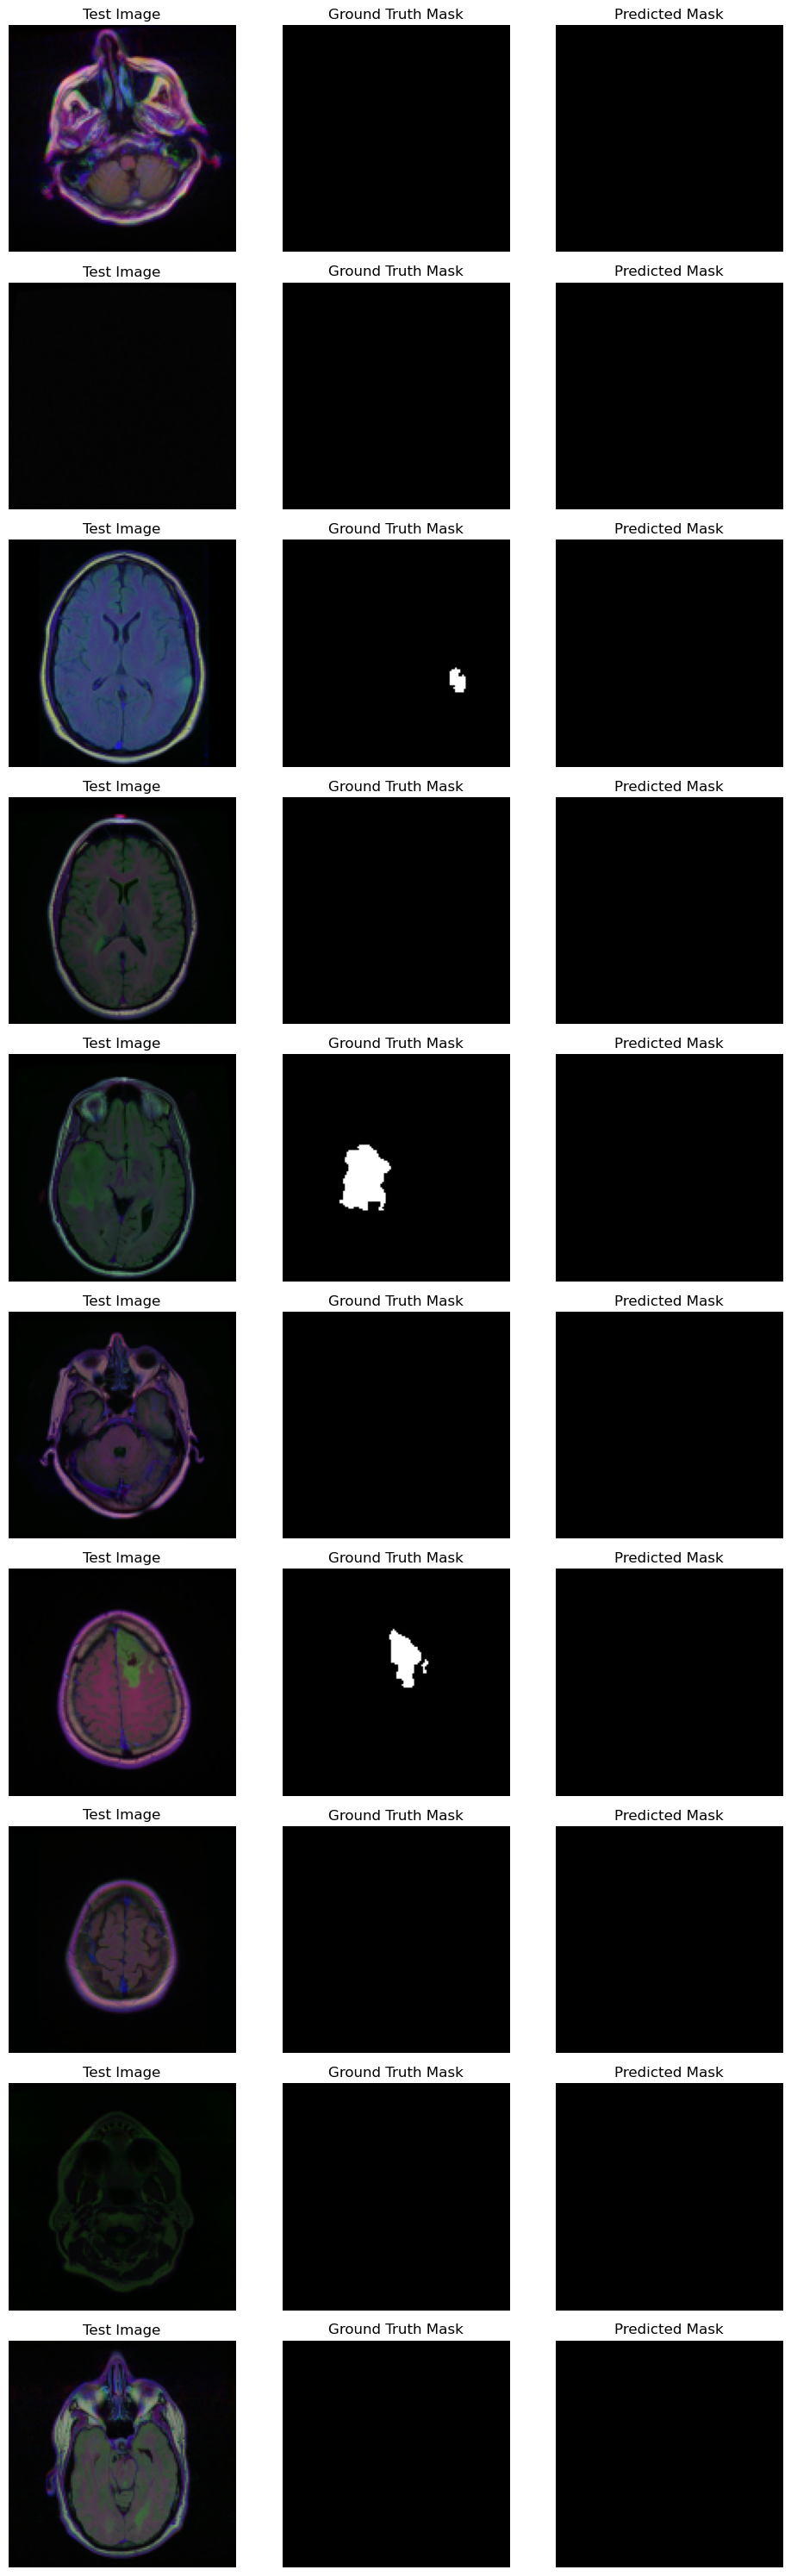

In [ ]:
# Predict on test set
Y_pred = model.predict(X_test)
Y_pred_thresholded = Y_pred > 0.5

# Display 10 test images with ground truth and predicted masks
num_images_to_display = 10
indices = random.sample(range(X_test.shape[0]), num_images_to_display)

plt.figure(figsize=(10, num_images_to_display * 3))

for i, idx in enumerate(indices):
    img = X_test[idx]
    mask_true = Y_test[idx].squeeze()
    mask_pred = Y_pred_thresholded[idx].squeeze()
    
    # Plot image
    plt.subplot(num_images_to_display, 3, 3 * i + 1)
    plt.imshow(img)
    plt.title('Test Image')
    plt.axis('off')
    
    # Plot ground truth mask
    plt.subplot(num_images_to_display, 3, 3 * i + 2)
    plt.imshow(mask_true, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')
    
    # Plot predicted mask
    plt.subplot(num_images_to_display, 3, 3 * i + 3)
    plt.imshow(mask_pred, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    
plt.tight_layout()
plt.show()